## Introducción al aprendizaje de máquinas: Regresión. 

### Objetivos Notebook Introducción al aprendizaje de máquinas Regresión 

1. Implementar el Modelo de Nelson y Siegel en Python.
2. Mostrar dos diferentes métodos para su estimación.

### Índice: 

#### 1. Modelo de Nelson-Siegel. 
#### 2. Método 1 de Estimación de parámetros de Nelson Siegel. 
#### 3. Método 2 de Estimación de parámetros de Nelson Siegel. 
#### 4. Comparación de performance Método de Estimación del Nelson-Siegel. 

### 1. Modelo de Nelson-Siegel

El modelo de Nelson-Siegel presenta la siguiente ecuación para la estimación de la estructura término de la curva de rendimientos: 

$Y(t,\tau_{i}) = \beta_{0} + \beta_{1}(\frac{1-\exp(-\lambda\tau_{i})}{\lambda\tau_{i}} + \beta_{2}(\frac{1-\exp(-\lambda\tau_{i})}{\lambda\tau_{i}}-\exp(-\lambda\tau_{i})))$

Procedemos entonces primero importando las librerias que vamos a usar para estimar el modelo de Nelson y Siegel.

In [130]:
import os
from scipy.optimize import fmin
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

from librerias.extract_data import get_data
from librerias.extract_data import get_data 
from librerias.graphs import *
from librerias.NelsonSiegel import *


import matplotlib.pyplot as plt
import matplotlib.markers as mk
import matplotlib.ticker as mtick


In [131]:
# Líneas de código para extraer los datos desde la página del tesoro.
# yield_df = get_data(start_year=2000,end_year=2025)


In [132]:
# Líneas de código para consultar los datos una vez ya se halla generado el csv
yield_df = pd.read_csv(os.path.join('datos\\'+'yield.csv'), sep = ';', index_col = 0)
yield_df

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,
2000-12-29,5.89,5.70,5.32,5.11,5.06,4.99,5.16,5.12,5.59,5.46
2000-12-28,5.87,5.79,5.40,5.18,5.12,5.02,5.21,5.13,5.59,5.44
2000-12-27,5.75,5.68,5.32,5.10,5.04,4.99,5.17,5.11,5.58,5.45
2000-12-26,5.85,5.76,5.31,5.10,5.00,4.92,5.09,5.04,5.54,5.41
2000-12-22,5.27,5.52,5.25,5.10,5.02,4.93,5.07,5.02,5.52,5.40
...,...,...,...,...,...,...,...,...,...,...
2024-01-08,5.49,5.24,4.82,4.36,4.11,3.97,3.99,4.01,4.33,4.17
2024-01-05,5.47,5.24,4.84,4.40,4.17,4.02,4.04,4.05,4.37,4.21
2024-01-04,5.48,5.25,4.85,4.38,4.14,3.97,3.99,3.99,4.30,4.13


In [133]:
# Filtrar los datos específico de una serie para una fecha particular ejemplo 2018-10-31
yield_series = yield_df.loc["2018-10-31",:]
yield_series

3 Mo     2.34
6 Mo     2.49
1 Yr     2.69
2 Yr     2.87
3 Yr     2.93
5 Yr     2.98
7 Yr     3.07
10 Yr    3.15
20 Yr    3.30
30 Yr    3.39
Name: 2018-10-31, dtype: float64

Definimos algunas funciones para estandarizar la consulta de los datos del yield. Y definir algunos nodos que quisieramos interpolar. 

In [134]:
### 
def period_to_months(period):
    number, unit = period.split(' ')
    number = int(number)
    if unit == 'Yr':
        return number * 12
    return number

def standardizeYieldSeries(yield_series):
    yield_df = yield_series.to_frame()
    yield_df.columns = ['Yield']
    yield_df.loc['9 Mo',:] = np.nan
    yield_df.loc['4 Yr',:] = np.nan
    yield_df.loc['6 Yr',:] = np.nan
    yield_df.loc['8 Yr',:] = np.nan
    yield_df = yield_df.reset_index().rename(columns = {'index': 'TimePeriod'})
    yield_df['Yield'] = yield_df['Yield']/100
    yield_df['TimePeriodInMonths'] = yield_df['TimePeriod'].apply(period_to_months)
    yield_df = yield_df.sort_values('TimePeriodInMonths')
    yield_df['Maturity'] = yield_df['TimePeriodInMonths']/12
    # If you don't want to keep the 'TimePeriodInMonths' column, you can drop it
    yield_df = yield_df.reset_index(drop=True)
    return yield_df

yield_date = standardizeYieldSeries(yield_series)
yield_date

,TimePeriod,Yield,TimePeriodInMonths,Maturity
0,3 Mo,0.0234,3,0.25
1,6 Mo,0.0249,6,0.50
2,9 Mo,NaN,9,0.75
3,1 Yr,0.0269,12,1.00
4,2 Yr,0.0287,24,2.00
5,3 Yr,0.0293,36,3.00
6,4 Yr,NaN,48,4.00
7,5 Yr,0.0298,60,5.00
8,6 Yr,NaN,72,6.00
9,7 Yr,0.0307,84,7.00


In [135]:
# Creamos dos copias de la serie de yield original para albergar en cada una, una interpolación.  
yield_date_m1 = yield_date.copy()
yield_date_m2 = yield_date.copy()

### Método 1: Minimización del error cuadrático medi evaluando valores de β0, β1, β2 y λ

Procedemos con el primer algoritmo para encontrar lo parámetros de la ecuación de Nelson y Siegel. Particularmente usamos el algoritmo de Nelder-Mead Simplex implementado en Scipy para encontrar el minimizar el error cuadrático medio.

In [136]:
# Planteamos la función que se va a optimizar. 
def myval(c):
    df = yield_date.copy()
    df['NS'] =(c[0])+(c[1]*((1-np.exp(-df['Maturity']/c[3]))/(df['Maturity']/c[3])))+(c[2]*((((1-np.exp(-df['Maturity']/c[3]))/(df['Maturity']/c[3])))-(np.exp(-df['Maturity']/c[3]))))
    df['Residual'] =  (df['Yield'] - df['NS'])**2
    val = np.sum(df['Residual'])
    print("[β0, β1, β2, λ]=",c,", SUM:", val)
    return(val)

# Obtenemos los factores de carga betas. 
def getOptimalLoadings(myval, initial_guess):
    c = fmin(myval, initial_guess)
    return c 

# Obtenermos entonces los valores que minimizar el error cuadrático medio con dos argumentos que incluyen una primera idea de cuáles son los vaores correctos.  
c = getOptimalLoadings(myval, [0.01, 0.00, -0.01, 1.0])

# Separamos los parámetros de acuerdo al orden dispuesto. 
β0 = c[0]
β1 = c[1]
β2 = c[2]
λ = c[3]


[β0, β1, β2, λ]= [ 0.01  0.   -0.01  1.  ] , SUM: 0.004428935183714751
[β0, β1, β2, λ]= [ 0.0105  0.     -0.01    1.    ] , SUM: 0.0042230191265077155
[β0, β1, β2, λ]= [ 1.0e-02  2.5e-04 -1.0e-02  1.0e+00] , SUM: 0.0043959085260602895
[β0, β1, β2, λ]= [ 0.01    0.     -0.0105  1.    ] , SUM: 0.00446256844392798
[β0, β1, β2, λ]= [ 0.01  0.   -0.01  1.05] , SUM: 0.004437124360930191
[β0, β1, β2, λ]= [ 1.025e-02  1.250e-04 -9.500e-03  1.025e+00] , SUM: 0.004279769471585108
[β0, β1, β2, λ]= [ 1.0375e-02  1.8750e-04 -9.7500e-03  9.6250e-01] , SUM: 0.004227573143192789
[β0, β1, β2, λ]= [ 1.05625e-02  2.81250e-04 -9.62500e-03  9.93750e-01] , SUM: 0.004136460329688963
[β0, β1, β2, λ]= [ 1.084375e-02  4.218750e-04 -9.437500e-03  9.906250e-01] , SUM: 0.003994355217247605
[β0, β1, β2, λ]= [ 1.0984375e-02  1.1718750e-04 -9.3437500e-03  9.8906250e-01] , SUM: 0.00397035505822668
[β0, β1, β2, λ]= [ 1.14765625e-02  5.07812500e-05 -9.01562500e-03  9.83593750e-01] , SUM: 0.003765835912419937
[β0, β1, β2

In [137]:

# Imprimimos entonces los parámetros. 
print("[β0, β1, β2, λ]=", [c[0].round(2), c[1].round(2), c[2].round(2), c[3].round(2)])

[β0, β1, β2, λ]= [0.03, -0.01, -0.0, 1.43]


In [138]:
# Definimos una función para interpolar los parámetros con base en su valor. 
def NelsonSiegel(df, β0, β1, β2, λ):
    df['NS'] =(β0)+(β1*((1-np.exp(-df['Maturity']/λ))/(df['Maturity']/λ)))+(β2*((((1-np.exp(-df['Maturity']/λ))/(df['Maturity']/λ)))-(np.exp(-df['Maturity']/λ))))
    df.style.format({'Maturity': '{:,.0f}'.format,'Yield': '{:,.2%}','NS': '{:,.2%}'})
    return df

In [139]:
# Imprimos los parámetros obtenidos por mediod de este problema de minimización.
print(β0,β1,β2,λ) 

0.033489694165432606 -0.01024299494807827 -2.2702714979699408e-07 1.4288908084266754


In [140]:
# Computamos la interpolación producto de usar los parámetros que recién obtuvimos con el modelo de Nelson y Siegel. 
yield_date_m1 = NelsonSiegel(yield_date_m1, β0, β1, β2, λ)
yield_date_m1

,TimePeriod,Yield,TimePeriodInMonths,Maturity,NS
0,3 Mo,0.0234,3,0.25,0.024093
1,6 Mo,0.0249,6,0.50,0.024847
2,9 Mo,NaN,9,0.75,0.025520
3,1 Yr,0.0269,12,1.00,0.026123
4,2 Yr,0.0287,24,2.00,0.027977
5,3 Yr,0.0293,36,3.00,0.029209
6,4 Yr,NaN,48,4.00,0.030053
7,5 Yr,0.0298,60,5.00,0.030651
8,6 Yr,NaN,72,6.00,0.031087
9,7 Yr,0.0307,84,7.00,0.031414


In [141]:
# Computamos el Error Cuadrático Medio a partir de los Parámetros obtenidos.
def computeMSE(yield_date):
    yield_date['Residual'] =  (yield_date['Yield'] - yield_date['NS'])**2
    yield_date = yield_date['Residual'].sum() 
    return yield_date

# Error Cuadrático Medio computado.
MSE = computeMSE(yield_date_m1.dropna())     
MSE

C:\Users\jcamargo\AppData\Local\Temp\ipykernel_21568\709663123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yield_date['Residual'] =  (yield_date['Yield'] - yield_date['NS'])**2


3.9960365889376906e-06

Gráficamos la interpolación obtenida frente a los nodos a los que teníamos acceso. 

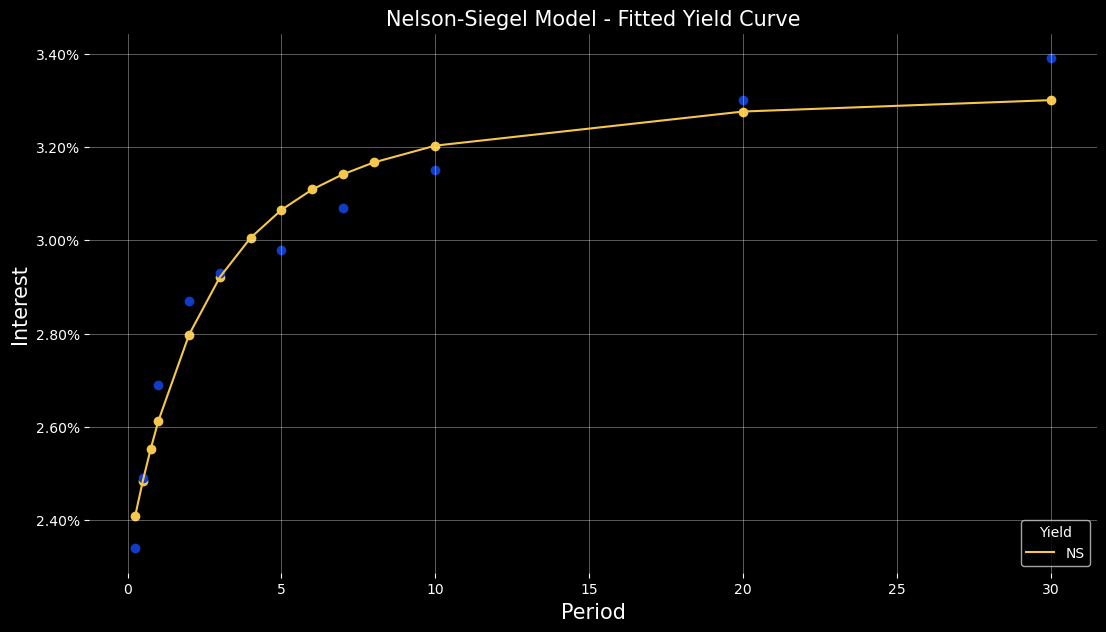

In [142]:
# Gráficamos la curva de rendimientos con sus respectivos nodos.
def plot_yield_curve(df):
    df['Y'] = round(df['Yield']*100,4)
    df['NS'] =(β0)+(β1*((1-np.exp(-df['Maturity']/λ))/(df['Maturity']/λ)))+(β2*((((1-np.exp(-df['Maturity']/λ))/(df['Maturity']/λ)))-(np.exp(-df['Maturity']/λ))))
    df['N'] = round(df['NS']*100,4)
    df2 = df.copy()
    df2 = df2.style.format({'Maturity': '{:,.2f}'.format,'Y': '{:,.2%}', 'N': '{:,.2%}'})
    
    plt.style.use('dark_background')
    fontsize=15
    fig = plt.figure(figsize=(13,7))
    ax = plt.axes()
    X = df["Maturity"]
    Y = df["Y"]
    x = df["Maturity"]
    y = df["N"]
    ax.plot(x, y, color="#F5C74D", label="NS") #orange
    plt.scatter(x, y, marker="o", c="#F5C74D") #orange
    plt.scatter(X, Y, marker="o", c="#103CC8") #blue
    plt.xlabel('Period',fontsize=fontsize)
    plt.ylabel('Interest',fontsize=fontsize)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend(loc="lower right", title="Yield")
    plt.grid(True, linewidth=0.5, alpha=0.5)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.title("Nelson-Siegel Model - Fitted Yield Curve",fontsize=fontsize)
    plt.show()

### Realizamos una imagen con la primera interpolación. 
plot_yield_curve(yield_date_m1)

### Método 2: Minimización del error cuadrático medio por medio de una grilla para los valores de $\lambda$.

Este segundo método para encontrar los valores óptimos del modelo de Nelson-Siegel, consideranod la metodología desarrollada en la investigación de Annaert, Claes, De Ceuster, Zhang (2000). Los cuáles considern el siguiente procedmiento para encontrar los parámetros: 

1. Generar una grilla para los valores de $\lambda$ entre $10^{-3}$ hasta $10^1$
2. Para cada nivel de $\lambda$ minimizar el error cuadrático del modelo respecto a los puntos observadores solucionando el problema de regresión lineal. 

Elegir aquel nivel de $\lambda$ y los betas que se encontraron para dicho nivel de $\lambda$ que menor error cuadráctico medio halla generado.

In [143]:
def estimateNelsonSiegel(df: pd.DataFrame, lambda_grid=None):
    """
    Estimate the Nelson-Siegel model using linear regression and grid search for lambda.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing 'Maturity' and 'Yield' columns.
    lambda_grid (array-like, optional): Grid of lambda values to search. Default is np.logspace(-3, 1, 50).
    
    Returns:
    dict: Best lambda, estimated parameters (beta0, beta1, beta2), and best RMSE.
    """
    if lambda_grid is None:
        lambda_grid = np.logspace(-3, 1, 1000)
    
    maturities = df["Maturity"].values
    yields = df["Yield"].values
    
    best_lambda = None
    best_rmse = float('inf')
    best_params = None
    
    for lambd in lambda_grid:
        # Compute explanatory variables
        X1 = (1 - np.exp(-lambd * maturities)) / (lambd * maturities)
        X2 = X1 - np.exp(-lambd * maturities)
        X = np.column_stack([np.ones_like(maturities), X1, X2])  # Add intercept
                
        # Solve linear regression
        model = LinearRegression(fit_intercept=False)
        model.fit(X, yields)
        y_pred = model.predict(X)
        
        # Compute RMSE
        rmse = np.sqrt(mean_squared_error(yields, y_pred))
        
        # Update best lambda if RMSE improves
        if rmse < best_rmse:
            best_rmse = rmse
            best_lambda = lambd
            best_params = model.coef_
    
    return {
        "best_lambda": best_lambda,
        "beta0": best_params[0],
        "beta1": best_params[1],
        "beta2": best_params[2],
        "best_rmse": best_rmse
    }
    
parameters_grid_search = estimateNelsonSiegel(yield_date_m2.dropna())

β0 = float(parameters_grid_search['beta0'])
β1 = float(parameters_grid_search['beta1'])
β2 = float(parameters_grid_search['beta2'])
λ = float(parameters_grid_search['best_lambda'])

In [144]:
# Imprimimos entonces los parámetros. 
print("[β0, β1, β2, λ]=", [c[0].round(2), c[1].round(2), c[2].round(2), c[3].round(2)])

[β0, β1, β2, λ]= [0.03, -0.01, -0.0, 1.43]


In [145]:
yield_date_m2 = NelsonSiegel(yield_date_m2, β0, β1, β2, λ)
yield_date_m2

,TimePeriod,Yield,TimePeriodInMonths,Maturity,NS
0,3 Mo,0.0234,3,0.25,0.024863
1,6 Mo,0.0249,6,0.50,0.026151
2,9 Mo,NaN,9,0.75,0.027183
3,1 Yr,0.0269,12,1.00,0.028015
4,2 Yr,0.0287,24,2.00,0.030089
5,3 Yr,0.0293,36,3.00,0.031115
6,4 Yr,NaN,48,4.00,0.031689
7,5 Yr,0.0298,60,5.00,0.032045
8,6 Yr,NaN,72,6.00,0.032284
9,7 Yr,0.0307,84,7.00,0.032456


In [146]:
def computeMSE(yield_date):
    yield_date['Residual'] =  (yield_date['Yield'] - yield_date['NS'])**2
    yield_date = yield_date['Residual'].sum() 
    return yield_date

MSE = computeMSE(yield_date_m2.dropna())     
MSE

C:\Users\jcamargo\AppData\Local\Temp\ipykernel_21568\422006213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yield_date['Residual'] =  (yield_date['Yield'] - yield_date['NS'])**2


2.0340049333132043e-05

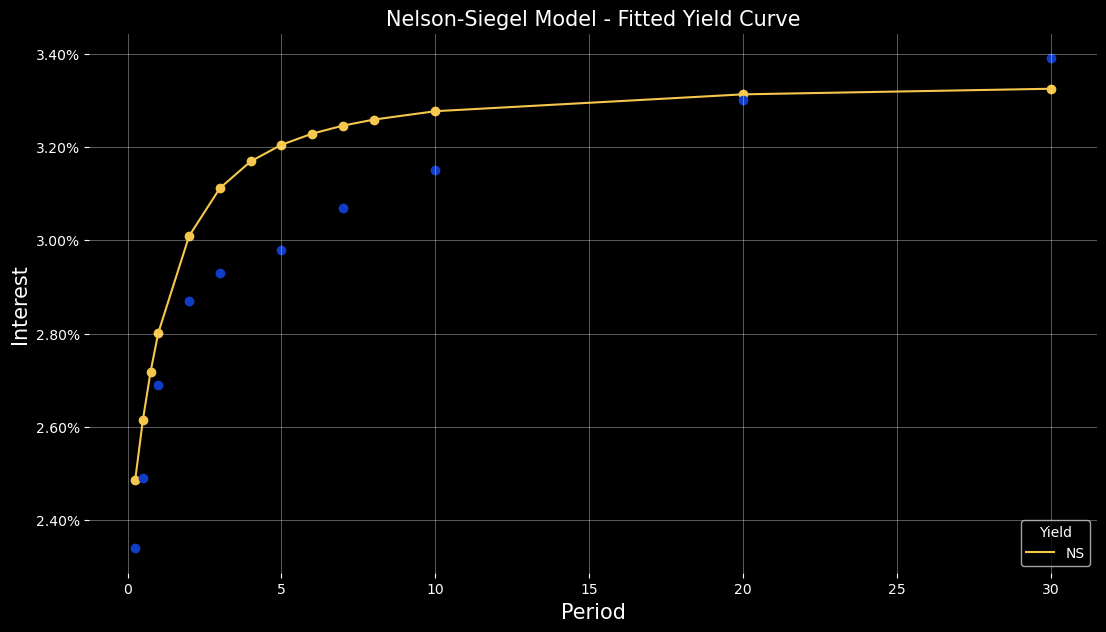

In [147]:
### Realizamos una imagen con la segunda interpolación. 
plot_yield_curve(yield_date_m2)

### Referencias

A continuación incluímos las referencias: 

Annaert, J., Claes, A. G., De Ceuster, M. J., & Zhang, H. (2010). Estimating the Yield Curve Using the Nelson‐Siegel Model. European Financial Management Association, Aarhus.